In [7]:
from envs.asu.env import ASUEnv, make_asu_env
import numpy as np 
import matplotlib.pyplot as plt 
import scipy.io as sio
import argparse
import gymnasium
import torch
from cleanrl.ppo_continuous_action import make_env, Agent
import seaborn as sns
import os 

sns.set_style("darkgrid")

## plot settings 

In [8]:
# matplotlib usful settings 
plt.rcParams['font.size'] = 8

COLORS = ([
    # deepmind style
	'#0072B2',
	'#009E73',
	'#D55E00',
	'#CC79A7',
	'#F0E442',
])

# global path settings 
data_path = './envs/asu/data/'
mpc_data = os.path.join(data_path, 'mpc_data')
rl_data = os.path.join(data_path, 'rl_data')

# load mpc data 
mpc_ysim = sio.loadmat(os.path.join(mpc_data, 'mpc_ysim.mat'))['ysim']
mpc_dusim = sio.loadmat(os.path.join(mpc_data, 'mpc_dusim.mat'))['dusim']
mpc_usim = sio.loadmat(os.path.join(mpc_data, 'mpc_usim.mat'))['usim']

# load rl data 
rl_dusim = np.load(os.path.join(rl_data, 'rl_dusim.npy'))
rl_usim = np.load(os.path.join(rl_data, 'rl_usim.npy'))
rl_dusim /= (np.array([6, 4e-3, 1e-2, 2e-3]) * 10)

# OV name 
y_name = ['FI101', 'FI102', 'FI103', 'AI5', 'AIAS102', 'AIAS103', 'AI701']
u_name = ['air flow', 'oxygen flow', 'nitrogen flow', 'V3 flow']

## Compare RL & MPC 
- data_path: `./envs/asu/data`
    - mpc: `os.path.join('data_path', 'mpc_data')`
    - rl:  `os.path.join('data_path', 'rl_data')`
    - results of rl is based on 4x4 system.
- Load `rl_dusim.npy`
- Test it on 4x7 system
- Load `mpc_ysim.mat`, compare results with rl 

In [9]:
# simulate with input data 
# get rl_ysim data 
rl_ysim = [] 
returns = 0

env = make_asu_env()
state, _ = env.reset()

while True:
    step = env.num_step
    rl_ysim.append(env.ysim[step, :])
    a = rl_dusim[step, :]
    state, reward, terminated, truncated, _ = env.step(a)
    done = np.logical_or(terminated, truncated)
    returns += reward
    if done:
        break 
print(f'total return: {np.mean(returns)}')
rl_ysim = np.array(rl_ysim)

total return: -75.84676462583394


In [10]:
rl_ysim[-1]
# mpc_ysim[-1]

array([9.84685286e+04, 1.88970153e+04, 3.97394843e+04, 1.56182581e+00,
       9.97356201e+01, 3.48591705e-01, 9.42696056e+00])

### ysim / usim comparison 

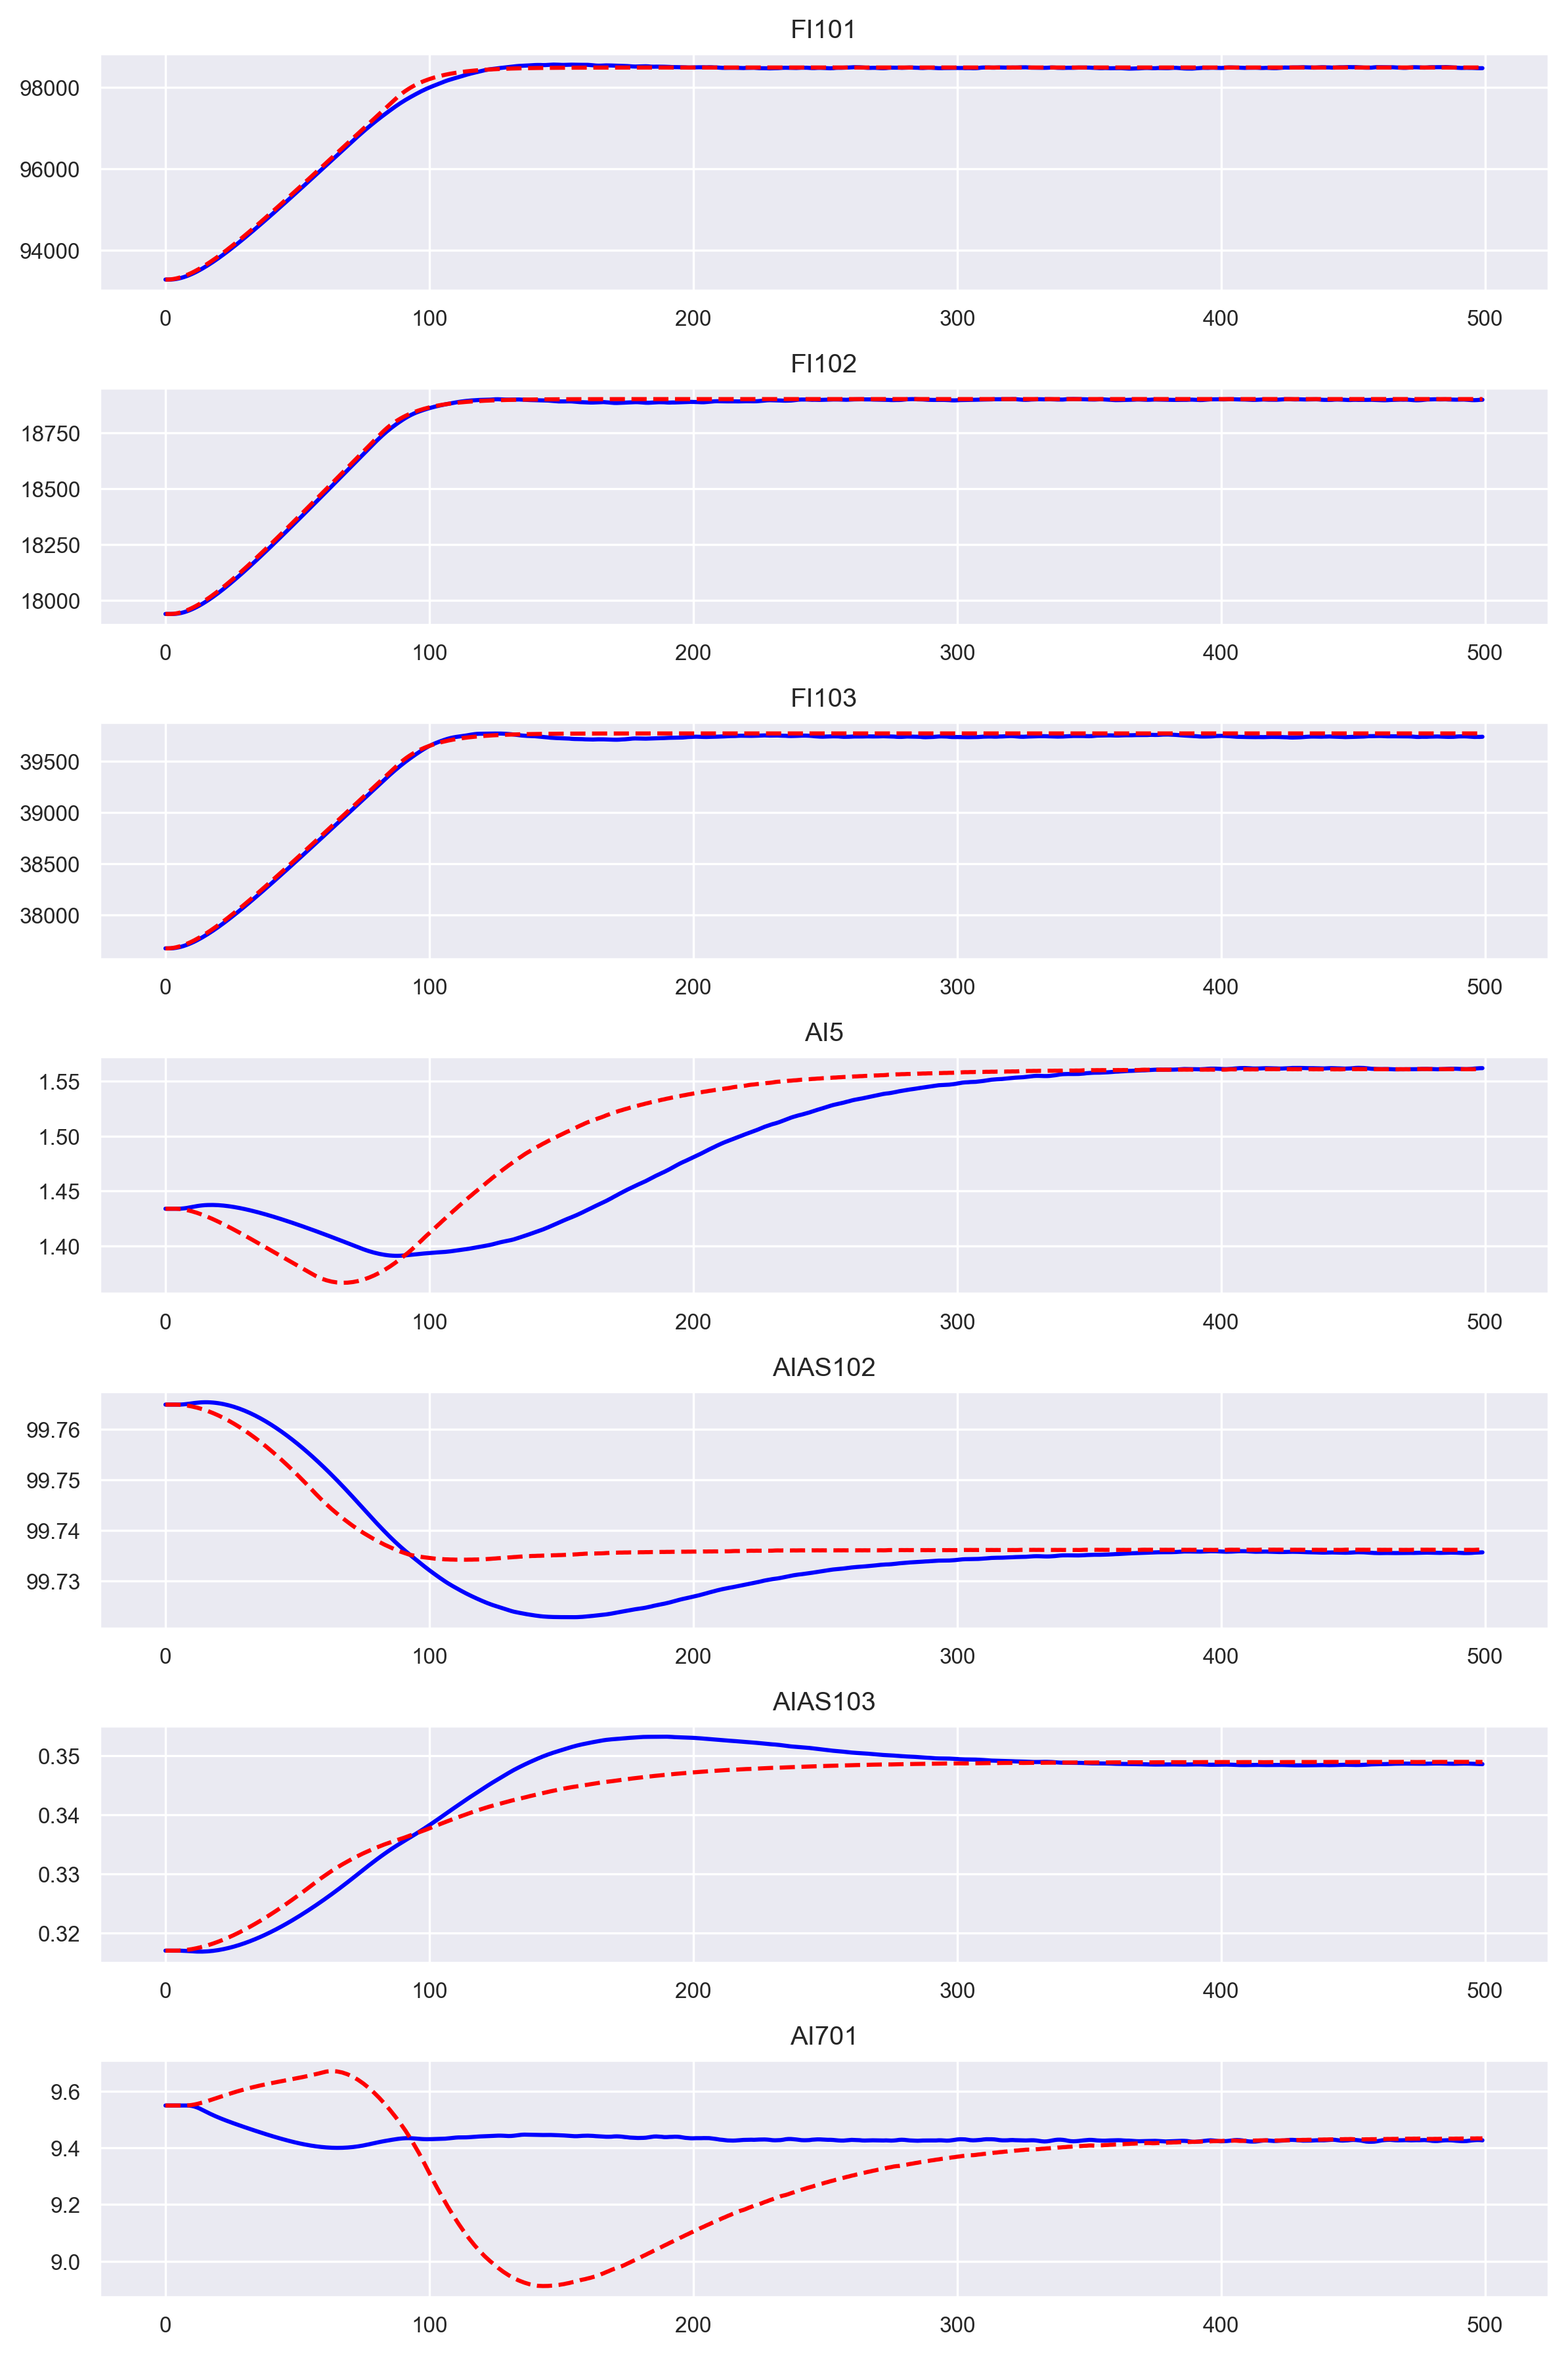

In [15]:
nrow = np.max([rl_ysim.shape[1], rl_usim.shape[1]])
fig, ax = plt.subplots(nrow, 1, figsize=(8, 12), dpi=300)
# plot y 
for i in range(rl_ysim.shape[1]):
    ax[i].plot(rl_ysim[:, i], label='RL', color='blue')
    ax[i].plot(mpc_ysim[:, i], label='MPC', color='red', linestyle='--')
    ax[i].grid(True) 
    ax[i].set_title(y_name[i])
plt.tight_layout()

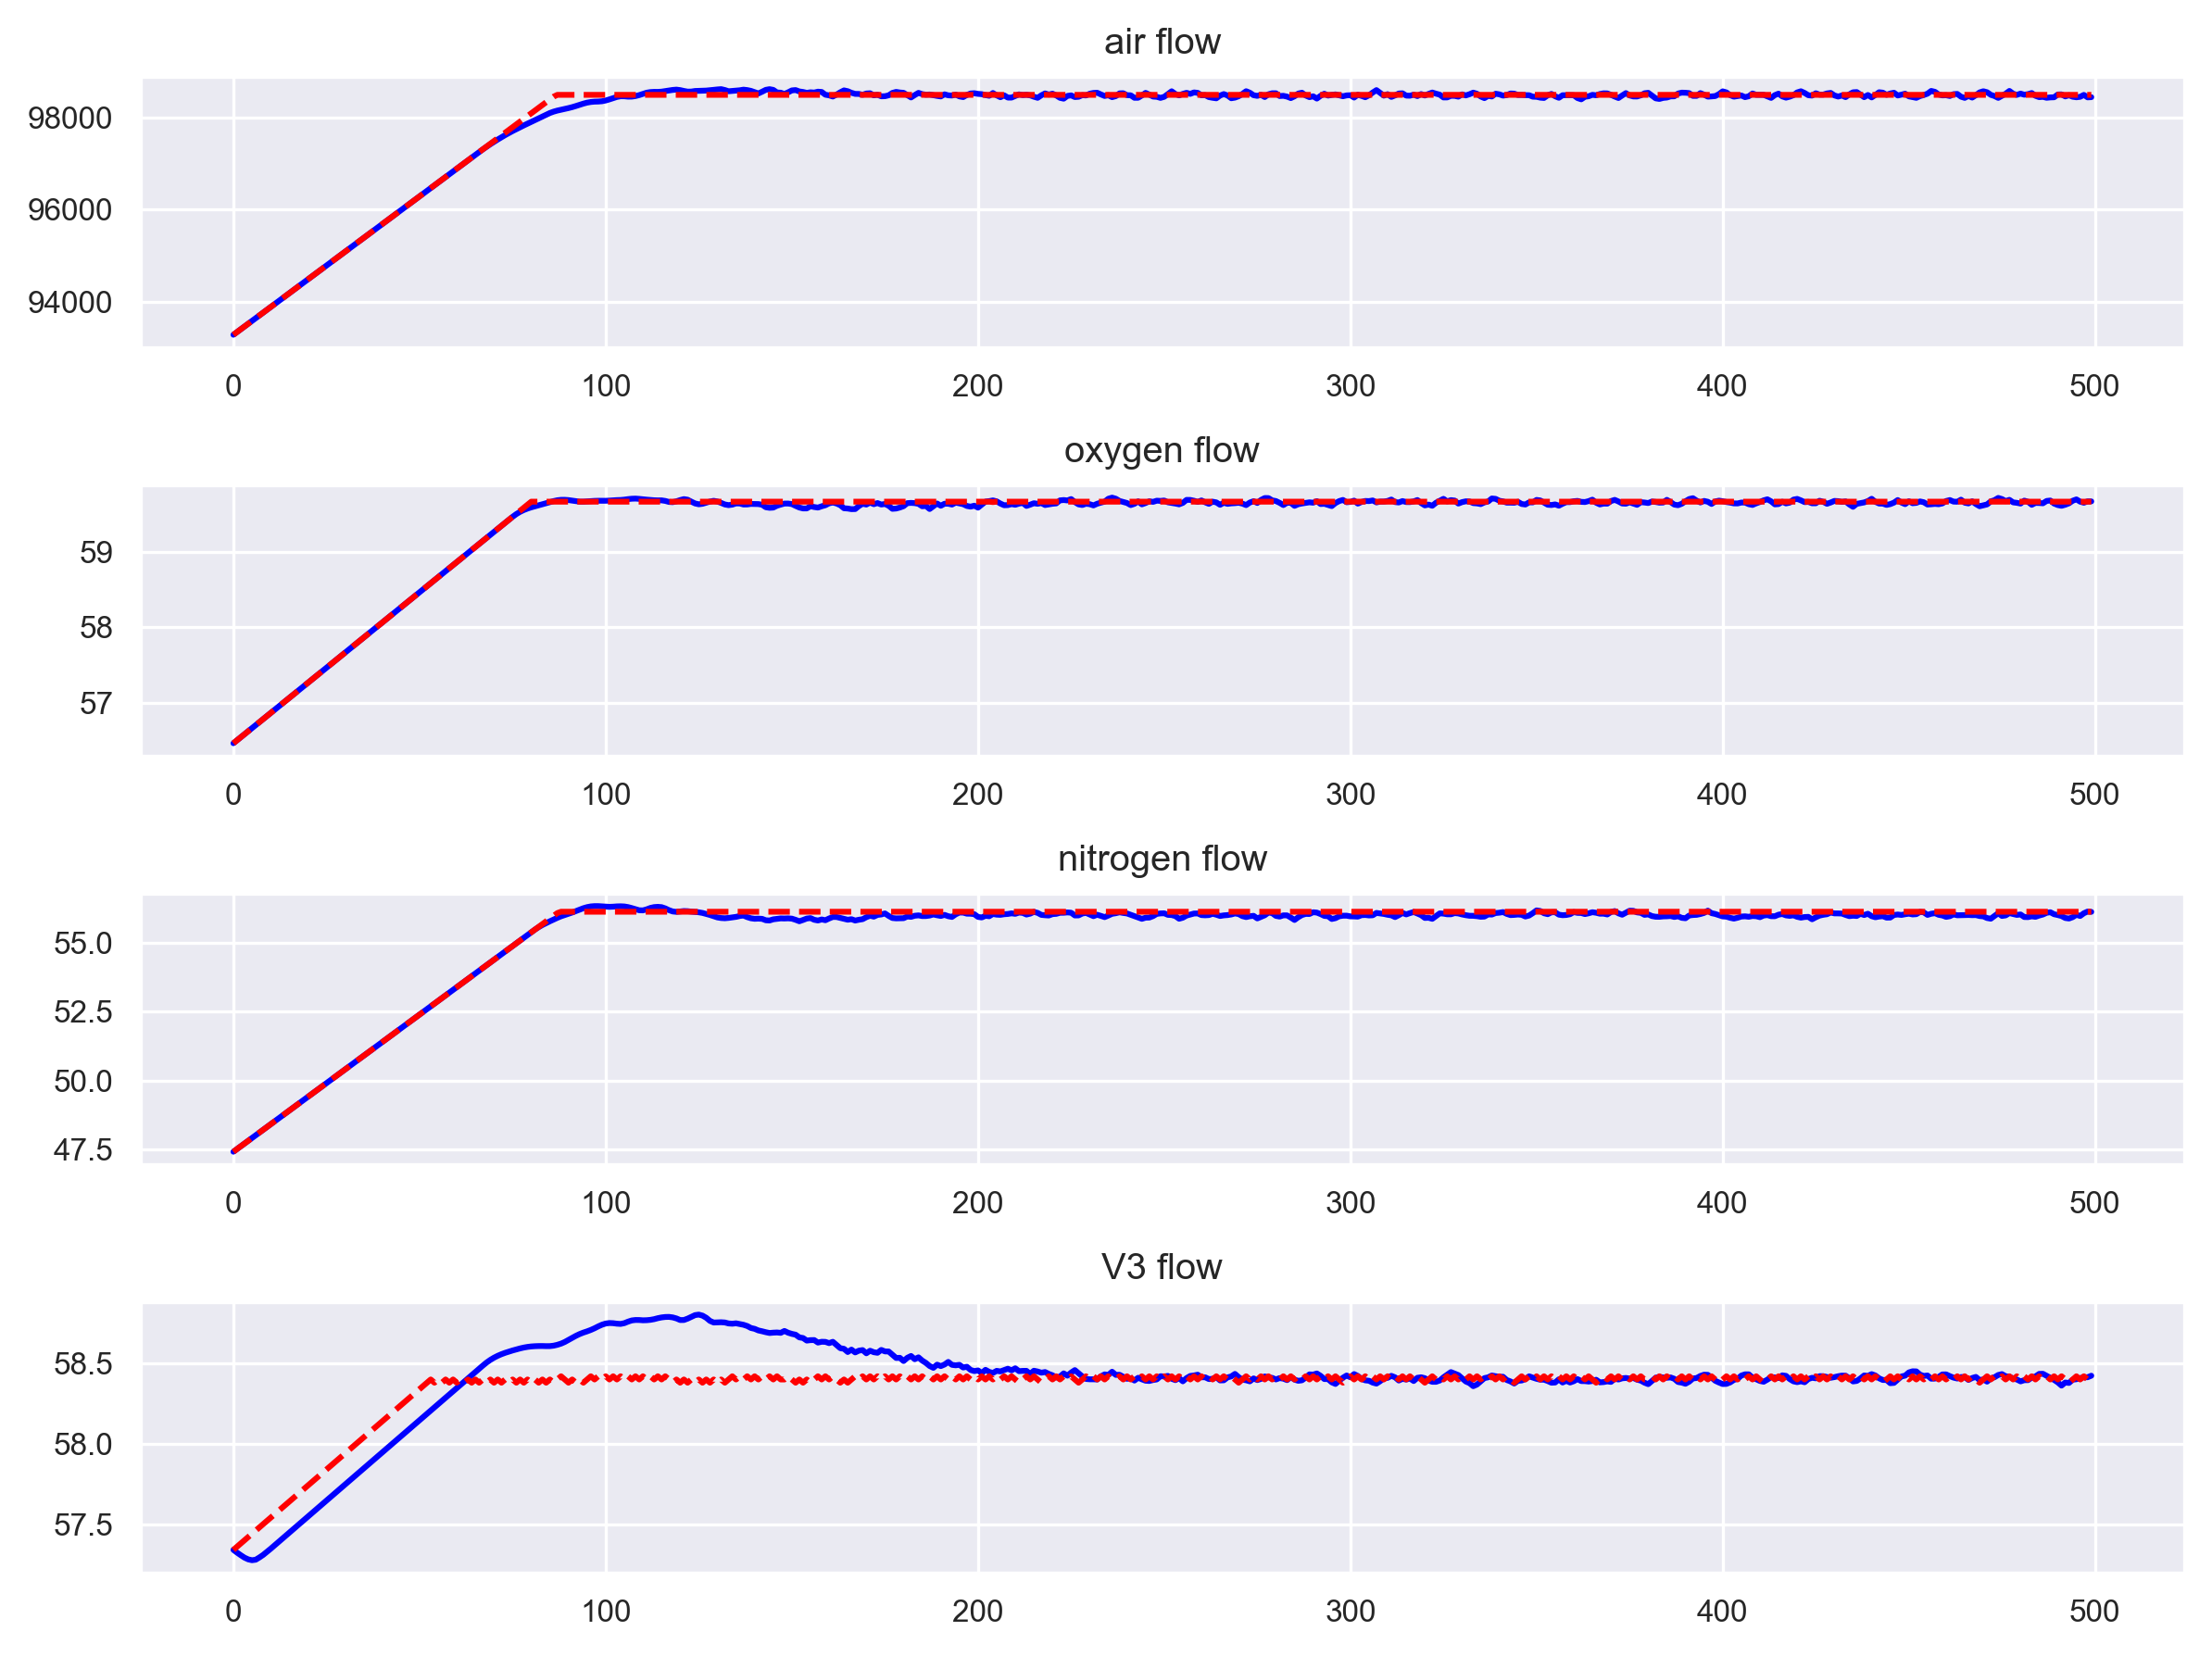

In [17]:
nrow = np.max([rl_ysim.shape[1], rl_usim.shape[1]])
fig, ax = plt.subplots(rl_usim.shape[1], 1, figsize=(8, 6), dpi=300)
# plot y 
for i in range(rl_usim.shape[1]):
    ax[i].plot(rl_usim[:, i], label='RL', color='blue')
    ax[i].plot(mpc_usim[:, i], label='MPC', color='red', linestyle='--')
    ax[i].grid(True) 
    ax[i].set_title(u_name[i])
plt.tight_layout()

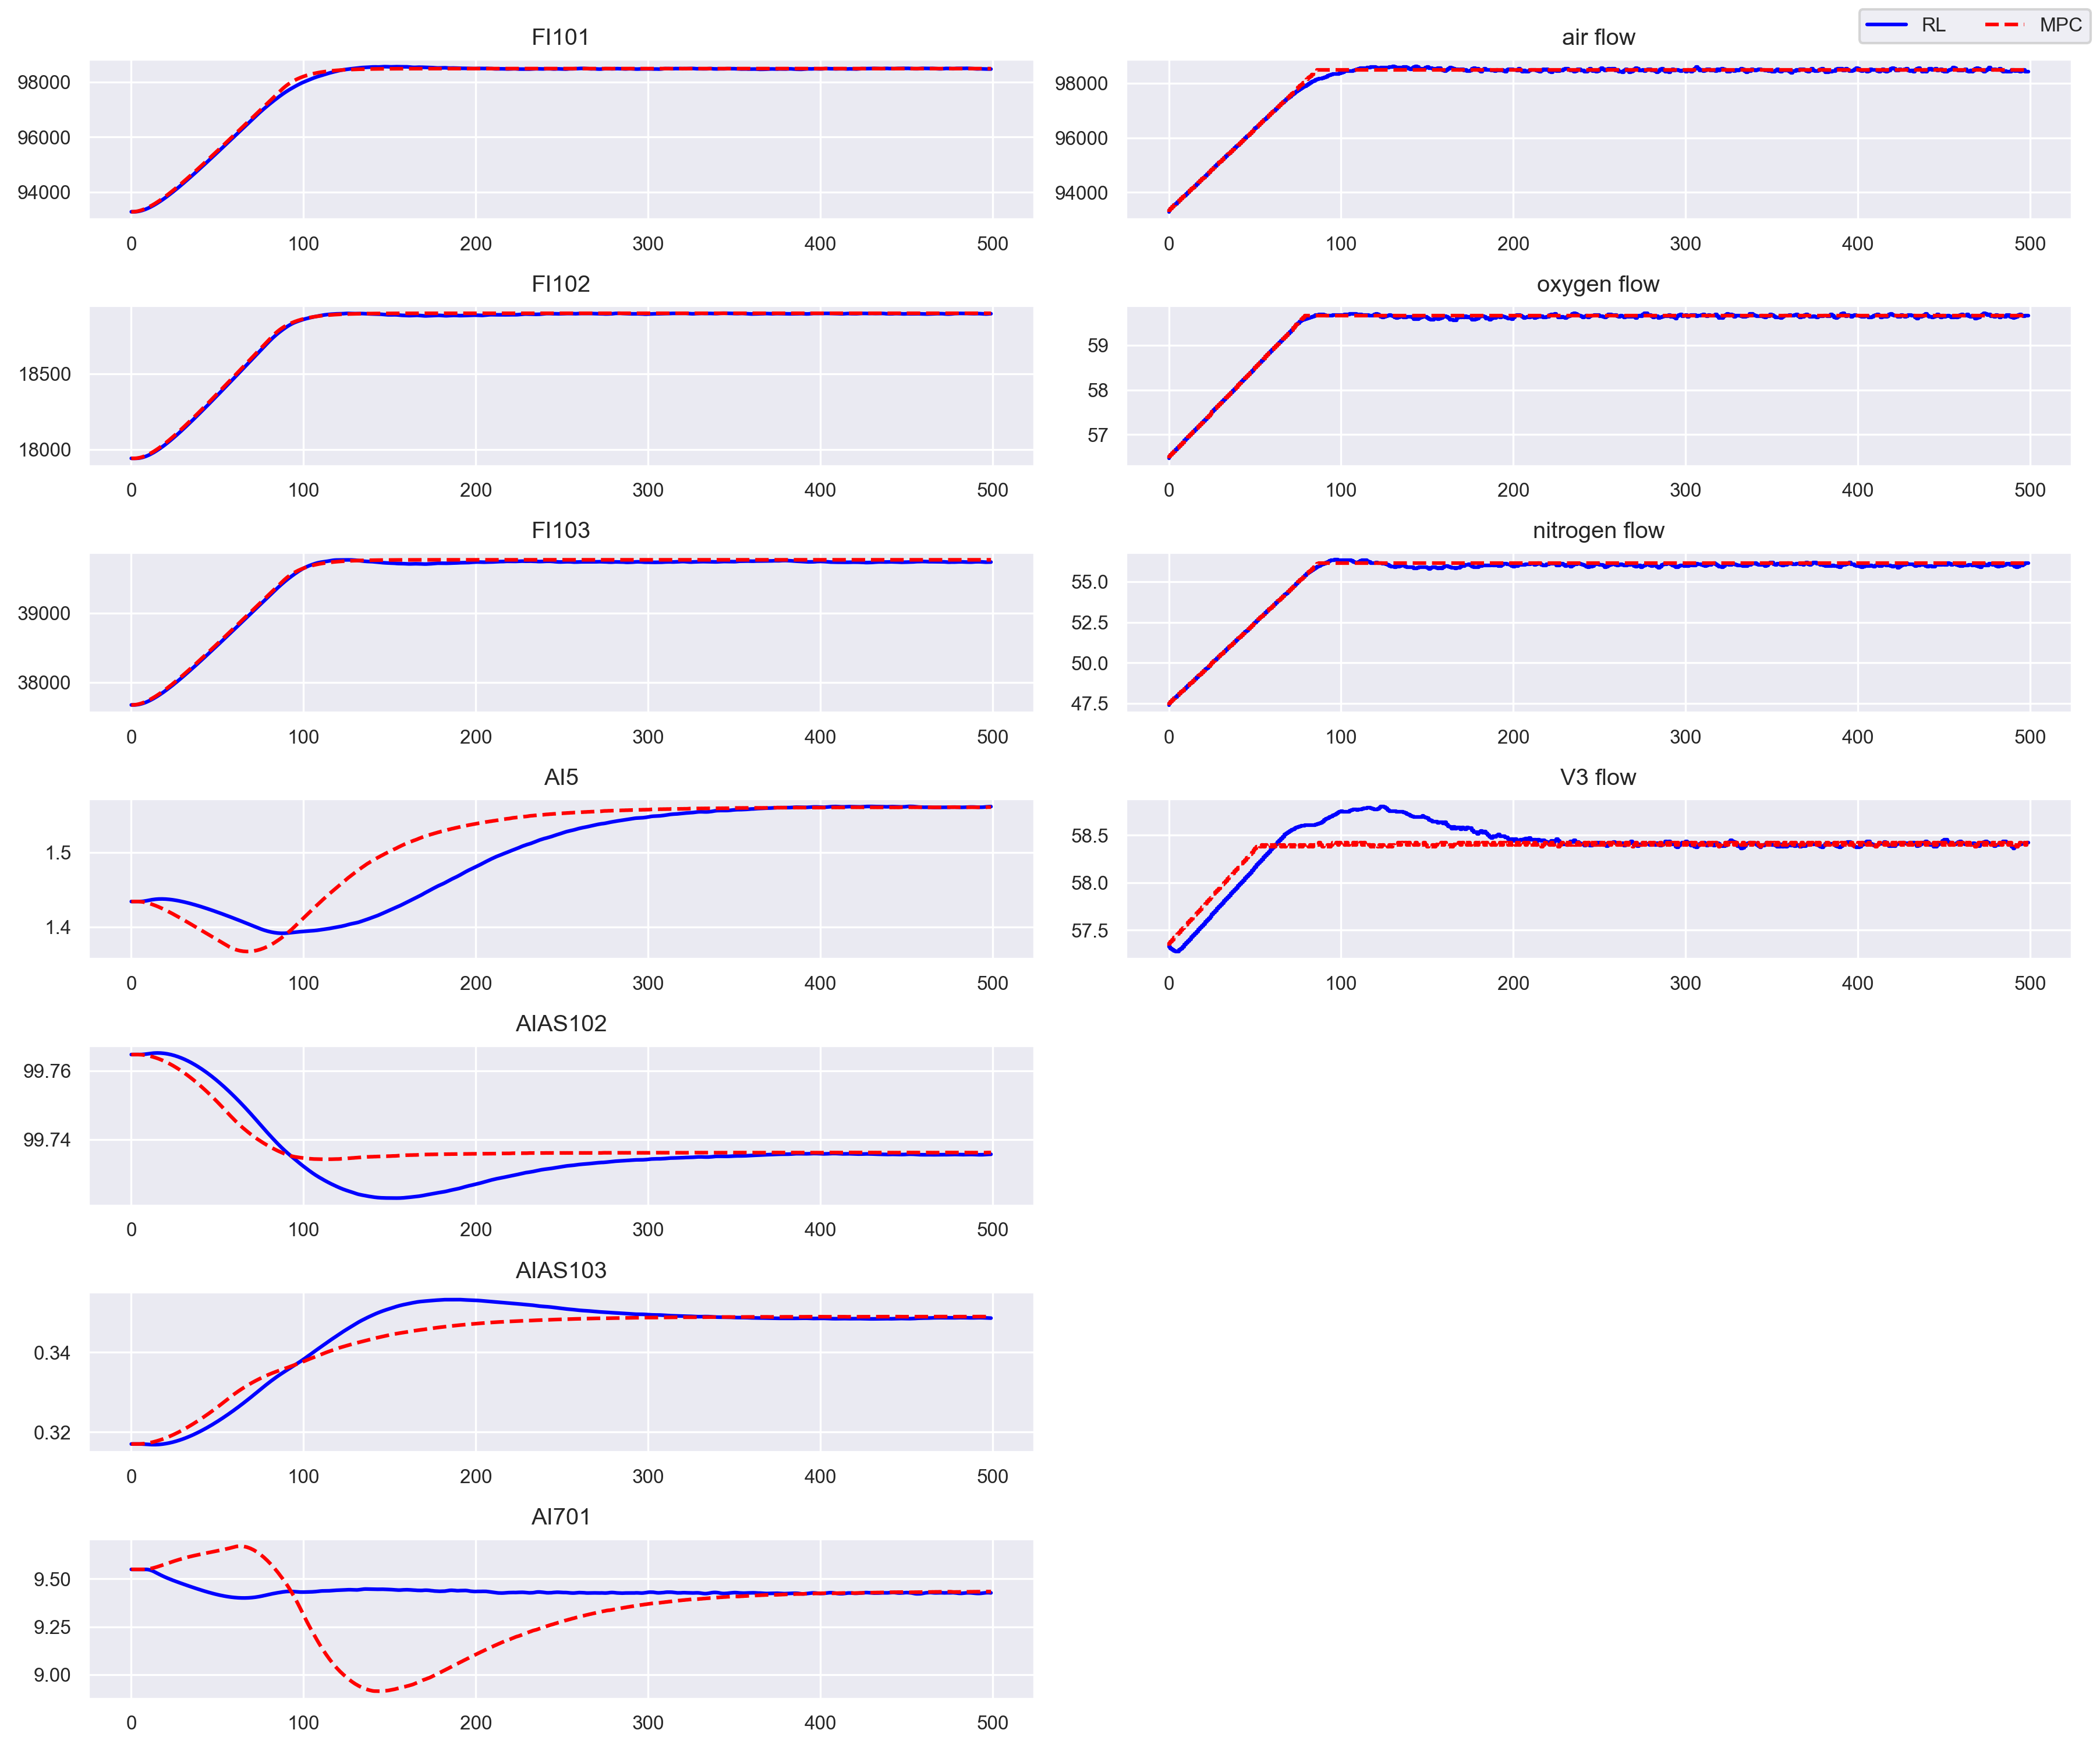

In [12]:
nrow = np.max([rl_ysim.shape[1], rl_usim.shape[1]])
fig, ax = plt.subplots(nrow, 2, figsize=(12, 10), dpi=300)
# plot y 
for i in range(rl_ysim.shape[1]):
    ax[i, 0].plot(rl_ysim[:, i], label='RL', color='blue')
    ax[i, 0].plot(mpc_ysim[:, i], label='MPC', color='red', linestyle='--')
    ax[i, 0].grid(True) 
    ax[i, 0].set_title(y_name[i])

# plot u 
for i in range(rl_usim.shape[1]):
    ax[i, 1].step(list(range(rl_usim.shape[0])), rl_usim[:, i], label='RL', color='blue')
    ax[i, 1].step(list(range(rl_usim.shape[0])), mpc_usim[:, i], label='MPC', color='red', linestyle='--')
    ax[i, 1].grid(True)
    ax[i, 1].set_title(u_name[i])
    
# invisible the rest of the axis
for i in range(rl_usim.shape[1], nrow, 1):
    ax[i, 1].set_visible(False)
    
lines, labels = ax[0, 0].get_legend_handles_labels()
fig.legend(lines, labels, loc='upper right', ncol=2)
plt.tight_layout()

In [ ]:
fig, ax = plt.subplots(rl_usim.shape[1], 1, figsize=(6, 12), dpi=300)
for i in range(rl_ysim.shape[1]):
    ax[i].plot(rl_ysim[:, i], label='RL', color='blue')
    ax[i].plot(mpc_ysim[:, i], label='MPC', color='red', linestyle='--')
    ax[i].grid(True) 
    ax[i].set_title(y_name[i])

lines, labels = ax[0].get_legend_handles_labels()
fig.legend(lines, labels, loc='upper right', ncol=3)
plt.tight_layout()

## RL agent test 

In [5]:
parser = argparse.ArgumentParser()
parser.add_argument("--qr", metavar=('q', 'r'), type=float, nargs=2, default=(1, 1),
        help="The (q, r) pair value for Shell env")
args = parser.parse_known_args()[0]

cfg = {
        'Tsim': 500,
        'obs_dict': False,
}
env_eval = gymnasium.vector.SyncVectorEnv(
    [make_env(1, i, False, 1, 0.99, args, env_cfg=cfg) for i in range(1)])

In [6]:
agent = Agent(env_eval)
# agent.load_state_dict(torch.load('./stable_models/ppo_continuous_action_stable4x4-0/best_agent.pt'))
agent.load_state_dict(torch.load('./models/ppo_continuous_action_stable4x4-5/best_agent.pt'))

next_obs, _ = env_eval.reset() 

goal = env_eval.envs[0].goal
ny = env_eval.envs[0].ny
nu = env_eval.envs[0].nu

e = [] 
y = []
du = []  
u = [] 
returns = []

r_mse, r_energy, r_overshoot = [], [], [] 

while True: 
    step = env_eval.envs[0].num_step
    e.append(env_eval.envs[0].state[ny:2*ny, -1])
    y.append(env_eval.envs[0].ysim[step, :])
    du.append(env_eval.envs[0].dusim[step, :])
    u.append(env_eval.envs[0].usim[step, :])
    with torch.no_grad():
        a = agent.actor_mean(torch.FloatTensor(next_obs))
        next_obs, reward, terminated, truncated, infos = env_eval.step(a.cpu().numpy())
    done = np.logical_or(terminated, truncated)
    
    if 'r_mse' in infos:
        r_mse.append(infos['r_mse'][0])
        r_energy.append(infos['r_energy'][0])
        r_overshoot.append(infos['r_overshoot'][0])

    if "final_info" not in infos:
            continue
    for info in infos["final_info"]:
        if info is None:
            continue
        returns.append(info["episode"]["r"])

    if done: 
         break 
    
print('----------- EVALUATION ---------------')
print('EPISODE REWARD: ', np.average(returns))
print('--------------------------------------')

e = np.array(e)
y = np.array(y)
du = np.array(du)
u = np.array(u)

print('----------- INFOS --------------------')
print('START: ', y[0])
print('GOAL: ', goal.reshape(-1))
print('y FINAL: ', y[-1])
print('error: ', y[-1] - goal.reshape(-1))
print('relative error: ', (y[-1] - goal.reshape(-1)) / goal.reshape(-1) * 100)
print('e FINAL: ', e[-1])
print('--------------------------------------')

----------- EVALUATION ---------------
EPISODE REWARD:  -13.773889
--------------------------------------
----------- INFOS --------------------
START:  [9.3285e+04 1.7940e+04 3.7672e+04 9.5500e+00]
GOAL:  [9.8485e+04 1.8900e+04 3.9772e+04 9.4285e+00]
y FINAL:  [9.84071007e+04 1.88972466e+04 3.97667910e+04 9.42091442e+00]
error:  [-7.78992887e+01 -2.75340475e+00 -5.20904138e+00 -7.58557811e-03]
relative error:  [-0.07909762 -0.01456828 -0.01309726 -0.08045371]
e FINAL:  [ 0.01498063  0.00286813  0.0024805  -0.06243274]
--------------------------------------


### save rl data 

In [7]:
np.save(os.path.join(rl_data, 'rl_dusim.npy'), du)
np.save(os.path.join(rl_data, 'rl_usim.npy'), u)
np.save(os.path.join(rl_data, 'rl_ysim.npy'), y)

### test visualization 

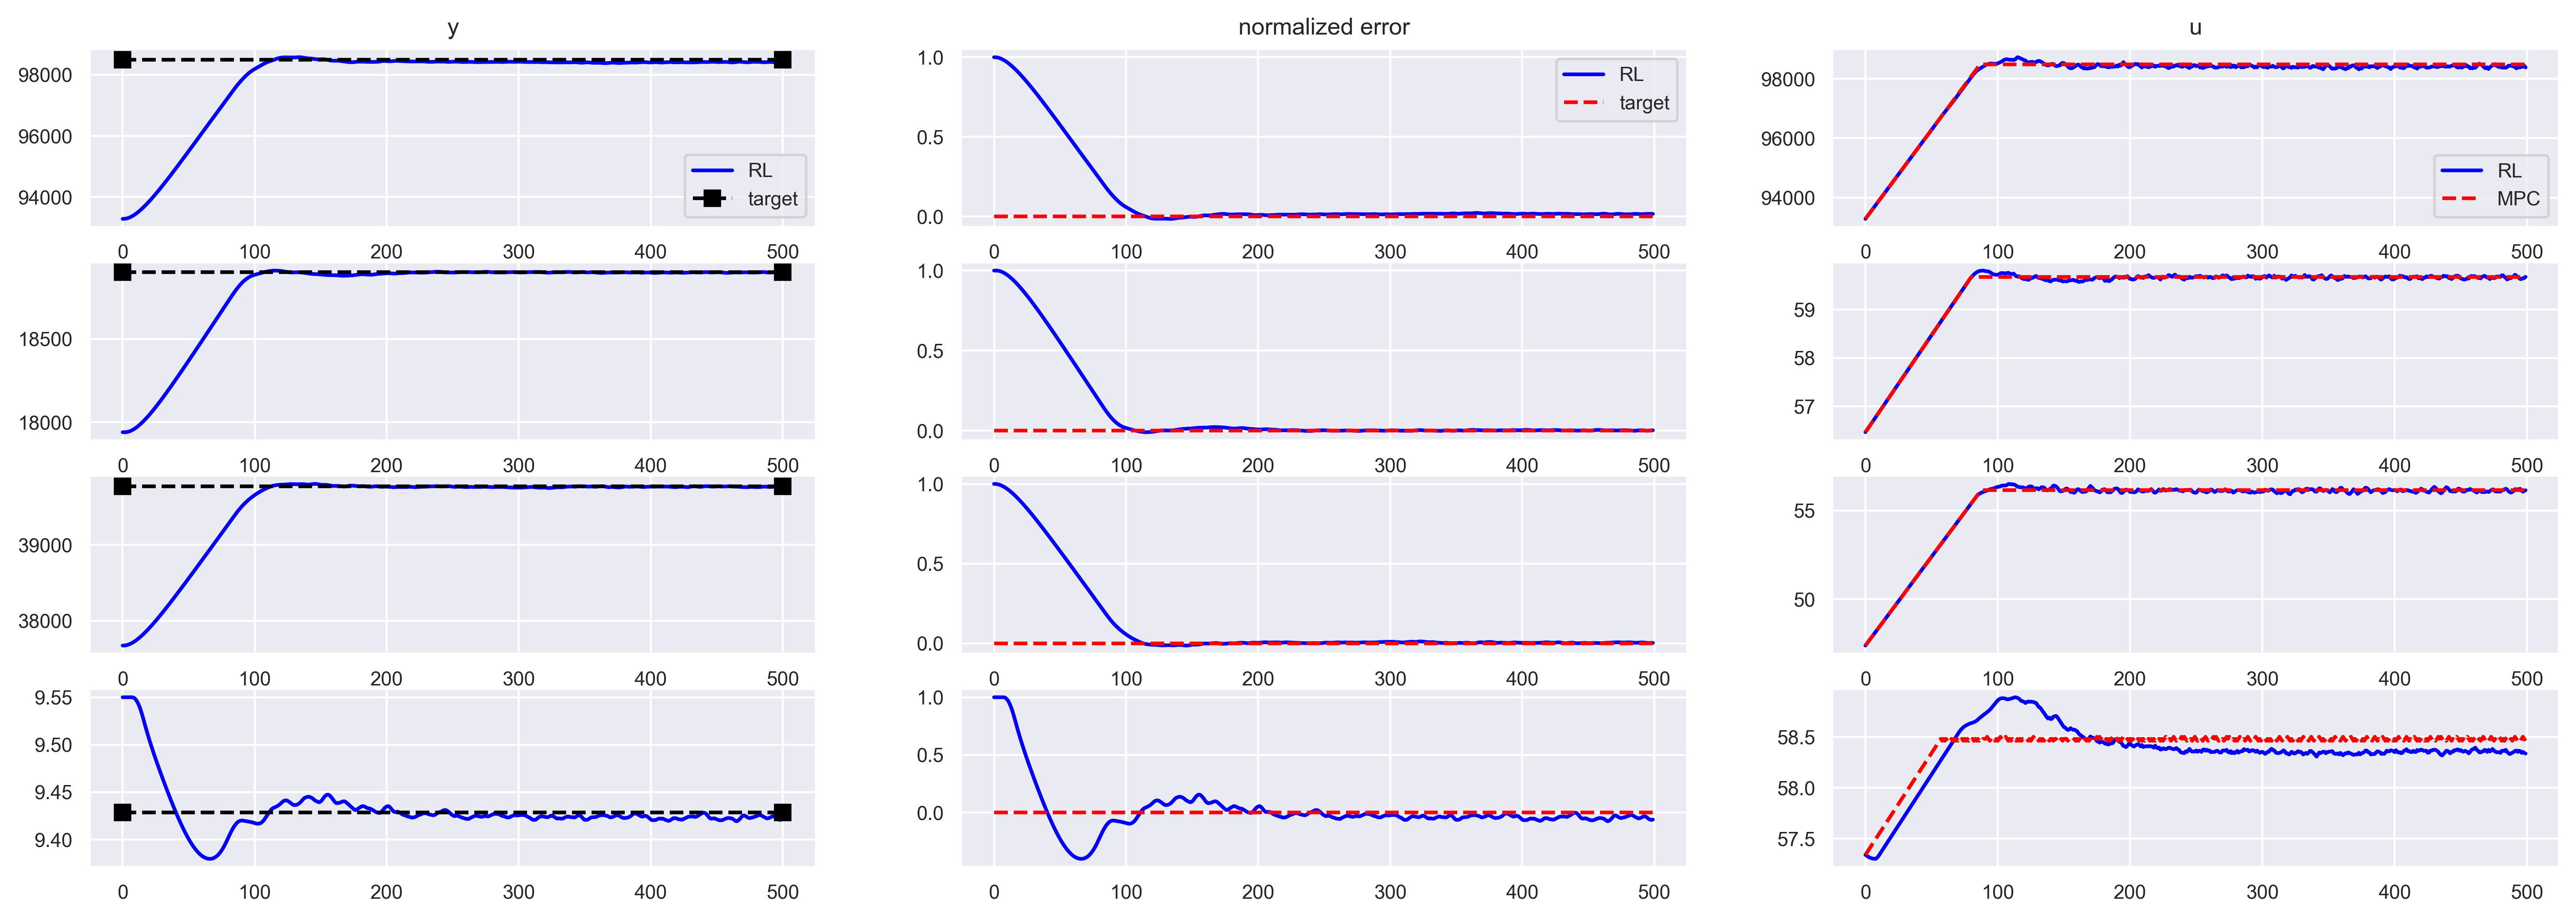

In [7]:
# select y index to be shown 
sel_y_idx = [0, 1, 2, 6]

fig, axs = plt.subplots(np.max([ny, nu]), 3, figsize=(18, 6), dpi=400)
# plot y
for i in range(ny):
    axs[i, 0].plot(y[:, i], 'b-', label='RL')
    # axs[i, 0].plot(mpc_ysim[:, sel_y_idx[i]], 'r--', label='MPC')
    axs[i, 0].plot([0, 500], [goal[i], goal[i]], 'sk--', label='target') 
    axs[i, 0].grid(True)
    if i == 0:
        axs[i, 0].legend(loc='lower right')
        axs[i, 0].set_title('y')
# plot e 
for i in range(ny):
    axs[i, 1].plot(e[:, i], 'b-', label='RL')
    axs[i, 1].plot([0, 500], [0, 0], 'r--', label='target')
    axs[i, 1].grid(True)
    if i == 0:
        axs[i, 1].legend(loc='upper right') 
        axs[i, 1].set_title('normalized error')
# plot u
for i in range(nu):
    axs[i, 2].plot(u[:, i], 'b-', label='RL')
    axs[i, 2].plot(mpc_usim[:, i], 'r--', label='MPC')
    axs[i, 2].grid(True)
    # axs[-1, 2].set_ylim([0, 0.008])
    if i == 0:
        axs[i, 2].legend(loc='lower right') 
        axs[i, 2].set_title('u')


Text(0.5, 1.0, 'overshoot')

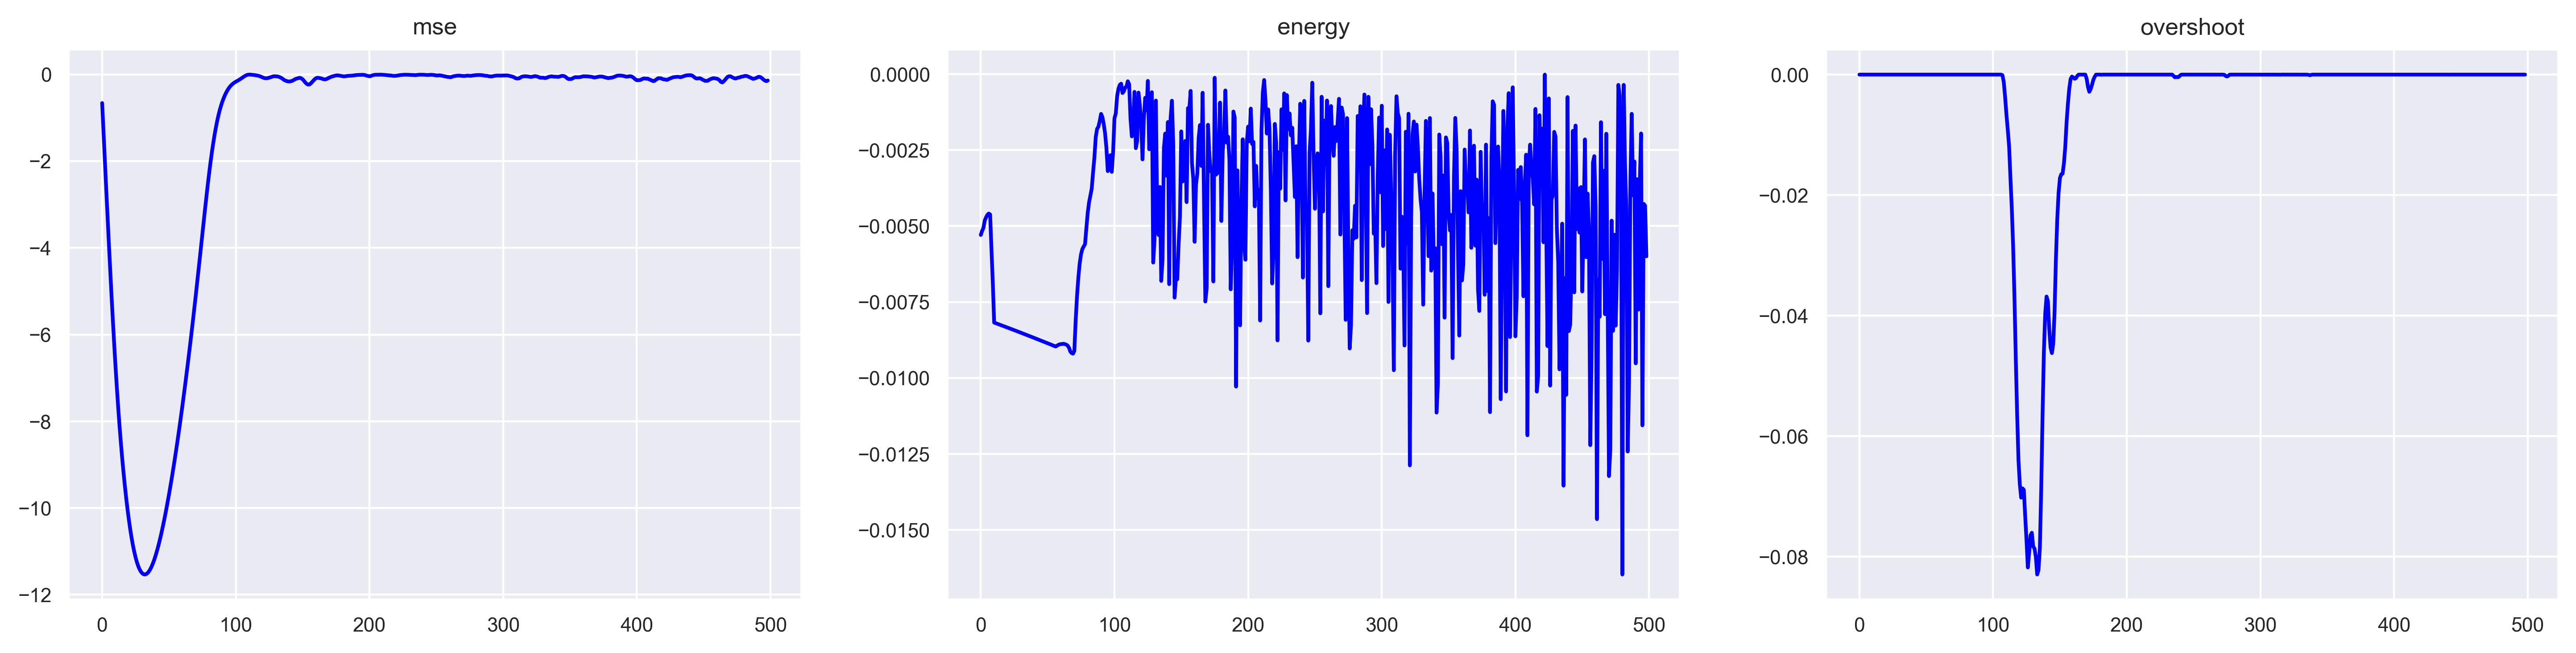

In [8]:
# show specific reward distribution during an episode 
fig, axs = plt.subplots(1, 3, figsize=(18, 4), dpi=400)
axs[0].plot(r_mse, 'b-', label='RL')
axs[0].grid(True)
axs[0].set_title('mse')
axs[1].plot(r_energy, 'b-', label='RL')
axs[1].grid(True)
axs[1].set_title('energy')
axs[2].plot(r_overshoot, 'b-', label='RL')
axs[2].grid(True)
axs[2].set_title('overshoot')